In [2]:
import pickle
from pathlib import Path
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML
from mmcv import Config
import csv
from slurm.utils.commons.labelmaps import labelmaps

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [3]:
p_dir = Path('work_dirs/train_output/hmdb2ucf/tsm/gcd4da/vanilla/phase0/default/9066__gcd4da-phase0-tsm_hmdb2ucf-from-vanilla-after-norm/26/20220910-010304/logits')
# p_dir = Path('work_dirs/train_output/ucf2hmdb/tsm/gcd4da/vanilla/phase0/default/9063__gcd4da-phase0-tsm_ucf2hmdb-from-vanilla-after-norm/34/20220910-051042/logits')
# p_dir = Path('work_dirs/train_output/ucf2hmdb/tsm/gcd4da/median/phase0/randomalpha/9069__gcd4da-median-phase0-tsm_ucf2hmdb/18/20220910-091819/logits')
p_config, = p_dir.parent.glob('*.py')
config = Config.fromfile(p_config)
p_pkls = sorted(p_dir.glob('*.pkl'))
xs = []
for p_pkl in p_pkls:
    with p_pkl.open('rb') as f:
        x = pickle.load(f)
    xs.append(x)
    print(x.shape)
xs = xs[:-2]

(327, 12)
(327, 12)
(327, 12)
(327, 12)
(327, 12)
(327, 12)
(327, 12)
(327, 12)
(327, 12)
(327, 12)
(380, 12)
(380, 12)


In [4]:
with open(config.data.val.ann_file) as f:
    reader = csv.reader(f, delimiter=' ')
    ann = [int(line[-1]) for line in reader]
preds = [x.argmax(axis=1) for x in xs]
len(ann), len(preds[0])

(327, 327)

In [5]:
X = np.array(xs)
X = X.reshape(-1, X.shape[-1])
X = X / np.std(X[:, 0]) * 1e-4
TSNE_model = TSNE(n_components=2, learning_rate='auto', init='pca')
tsne = TSNE_model.fit_transform(X)
tsne = tsne.reshape(len(xs), -1, 2)
tsne.shape

/data/hyogun/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


(10, 327, 2)

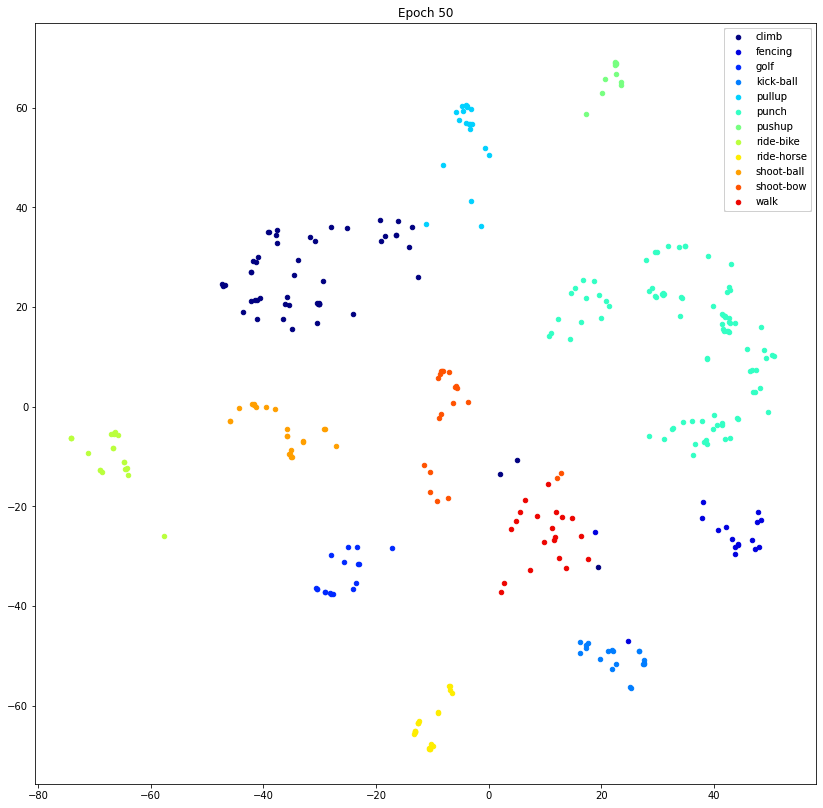

In [7]:
camera = Camera(plt.figure(figsize=(14, 14)))
cmap = plt.get_cmap('jet')
hi = True
plt.title('HMDB->UCF TSM Contra phase0 w/o Debiasing validation logits', fontsize=18)
for i, (epoch_feat, pred) in enumerate(zip(tsne, preds)):
    for c in range(12):
        plt.scatter(*epoch_feat[np.array(ann)==c].T, s=20, color=cmap(21*c), label=labelmaps['ucf'][c])
    if hi:
        plt.gca().set_title(f'Epoch {5*(i+1)}')
        plt.legend(loc=0)
        hi = False
    camera.snap()
anim = camera.animate(blit=True, interval=1000)
HTML(anim.to_html5_video())